# Can CNNs outperform MLPs in shuffled datasets?

The following notebooks shoes the results of the /scripts/tune.py and /scripts/train.py models.

Can CNNs outperform MLPs in image classification when both models have a comparable number of trainable parameters? We hypothesize CNNs  will outperform MLPs in intact images with spatial structure, but when we shuffle all columns and rows, MLPs will perform better due to CNNs reliance of spatial structure.

### Run these cells in sequence to:

1. Load and combine all results.

2. Plot training/validation loss curves by shuffled and unshuffled data.

3. Generate boxplots for metrics (parameters, precision, F1-score, accuracy, and recall) and statistical anslysis.

4. Display a summary table with average metrics for each dataset and model type.

## 1. Load Required Libraries


In [195]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, ttest_ind, mannwhitneyu


# Set global Seaborn style
sns.set(style="whitegrid")

## 2. Define Paths for Results


In [196]:
# Define paths (update these according to your directory structure)
output_path = f"{os.getcwd()}/../results/"
model_types = ["MLP", "MLP_3CH", "CNN", "CNN_3CH"]
datasets = ["MNIST", "MNISTshuffled", "FashMNIST", "FashMNISTshuffled", "CIFAR10", "CIFAR10shuffled"]

# Group MLP and CNN variants
model_group_mapping = {
    "MLP": "MLP",
    "MLP_3CH": "MLP",
    "CNN": "CNN",
    "CNN_3CH": "CNN"
}

## 3. Helper Functions

#### Load Results from CSV and JSON

In [197]:
def load_results(model_type, dataset):
    results_csv_path = os.path.join(output_path, f"results_{model_type}_{dataset}.csv")
    losses_json_path = os.path.join(output_path, f"losses_{model_type}_{dataset}.json")

    if os.path.exists(results_csv_path):
        results_df = pd.read_csv(results_csv_path)
    else:
        results_df = None

    if os.path.exists(losses_json_path):
        with open(losses_json_path, "r") as f:
            losses_dict = json.load(f)
    else:
        losses_dict = None

    return results_df, losses_dict

#### Plot boxplots for metrics

In [198]:

def plot_boxplot(combined_results, metric, title, ylim1, ylim2):
    plt.figure(figsize=(36, 18))  # Large figure for clarity

    # Custom dataset order, including a dummy spacer
    dataset_order = [
        "MNIST",
        "FashMNIST",
        "CIFAR10",
        "_spacer_",  # dummy category to create a gap
        "MNIST shuffled",
        "FashMNIST shuffled",
        "CIFAR10 shuffled"
    ]
    # Force a consistent hue order (so CNN bars are drawn first, then MLP)
    hue_order = ["CNN", "MLP"]

    # Filter out rows not in our desired set
    data_to_plot = combined_results[
        combined_results["data_type"].isin(dataset_order)
    ].copy()

    # Plot barplot
    ax = sns.barplot(
        x="data_type",
        y=metric,
        hue="model_group",
        data=data_to_plot,
        # Ensure CNN is always drawn first, then MLP
        hue_order=hue_order,
        palette={"CNN": "green", "MLP": "purple"},
        dodge=True,
        errorbar="ci",         # 95% CI by default
        err_kws={"linewidth": 10},   # thick error bars
        alpha=0.9,
        order=dataset_order,  # desired x order
        capsize=.50,
        edgecolor="black"
    )

    # -------------------------------------------------------------------
    # 1) Hatch bars ONLY for shuffled categories, for BOTH CNN & MLP
    # -------------------------------------------------------------------
    # Group the data by category, so we know how many bars each category has.
    # (One bar per distinct hue for that category.)
    grouped = data_to_plot.groupby("data_type")

    patch_index = 0

    # -------------------------------------------------------------------
    # 2) Replace x-axis labels to insert line breaks for "shuffled"
    # -------------------------------------------------------------------
    old_labels = [tick.get_text() for tick in ax.get_xticklabels()]
    new_labels = []
    for lbl in old_labels:
        if lbl == "_spacer_":
            new_labels.append("")  # hide the spacer label
        elif "shuffled" in lbl:
            # e.g. "MNIST shuffled" -> "MNIST\nshuffled"
            parts = lbl.split()
            if len(parts) == 2:
                new_labels.append(parts[0] + "\n" + parts[1])
            else:
                # fallback if it's a different format
                new_labels.append(lbl.replace("shuffled", "\nshuffled"))
        else:
            new_labels.append(lbl)
    ax.set_xticklabels(new_labels)

    # -------------------------------------------------------------------
    # 3) Styling
    # -------------------------------------------------------------------
    plt.title(title, fontsize=95, fontweight="bold", pad=40)
    plt.xlabel("Dataset", fontsize=65, fontweight="bold")
    plt.ylabel(f"{metric.capitalize()} Value", fontsize=60, fontweight="bold")
    plt.xticks(rotation=45, fontsize=55)
    plt.yticks(fontsize=45)
    plt.tick_params(labelsize=45)
    # Thicker grid lines & spines
    plt.grid(True, axis="y", linestyle="--", alpha=0.7, linewidth=4)
    plt.rcParams['axes.linewidth'] = 4
    plt.rcParams['grid.linewidth'] = 4

    # Move legend outside
    plt.legend(
        title="Model Type",
        fontsize=65,
        title_fontsize=70,
        loc="upper left",
        bbox_to_anchor=(1.05, 1)
    )

    plt.ylim(ylim1, ylim2)
    plt.tight_layout()
    plt.show()

#### Combine and Process All Results

In [199]:
# Combine results from all datasets and models
def combine_results(model_types, datasets):
    all_results = []
    all_losses = {}

    for model_type in model_types:
        for dataset in datasets:
            results_df, losses_dict = load_results(model_type, dataset)
            
            if results_df is not None:
                results_df["model_group"] = model_group_mapping[model_type]
                results_df["data_type"] = dataset
                results_df["shuffled"] = True if "shuffled" in dataset else False
                all_results.append(results_df)

            if losses_dict is not None:
                for key, value in losses_dict.items():
                    all_losses[f"{model_type}_{dataset}_{key}"] = {
                        "model_group": model_group_mapping[model_type],
                        "data_type": dataset,
                        "shuffled": "shuffled" if "shuffled" in dataset else "not_shuffled",
                        "train_losses": value["train_losses"],
                        "val_losses": value["val_losses"],
                    }

    combined_results = pd.concat(all_results, ignore_index=True) if all_results else pd.DataFrame()
    return combined_results, all_losses

#### Plotting the model sizes for comparison

In [200]:
import matplotlib.lines as mlines

def plot_model_size_comparison(combined_results):
    """
    Creates a violin + strip plot comparing the "Number of Parameters"
    between CNN and MLP across all experiments, with shuffled models marked as stars.
    """
    plt.figure(figsize=(24, 18))
    
    # Violin plot for overall distribution
    sns.violinplot(
        x="model_group", 
        y="Number of Parameters", 
        data=combined_results,
        palette={"CNN": "green", "MLP": "purple"},
        linewidth=4,
        width=0.5,
        cut=0,
        scale="width",
        inner="box"
    )
    
    # Plot non-shuffled models with circle markers
    non_shuffled = combined_results[combined_results["shuffled"] == False]
    sns.stripplot(
        x="model_group", 
        y="Number of Parameters", 
        data=non_shuffled,
        palette={"CNN": "black", "MLP": "black"},
        size=12,
        jitter=True,
        alpha=0.8,
        marker="o"
    )
    
    # Plot shuffled models with star markers
    shuffled = combined_results[combined_results["shuffled"] == True]
    sns.stripplot(
        x="model_group", 
        y="Number of Parameters", 
        data=shuffled,
        palette={"CNN": "black", "MLP": "black"},
        size=22,
        jitter=True,
        alpha=0.8,
        marker="*"
    )

    plt.title("Model Size Comparison", fontsize=80, fontweight="bold", pad=20)
    plt.xlabel("Model Type", fontsize=65, fontweight="bold", labelpad=15)
    plt.ylabel("Number of Parameters", fontsize=65, fontweight="bold", labelpad=15)
    plt.tick_params(labelsize=60)
    plt.grid(True, axis="y", linestyle="--", alpha=0.7, linewidth=4)

    # Disable scientific notation on the y-axis:
    ax = plt.gca()
    ax.ticklabel_format(axis='y', style='plain')
    
    # Create custom legend handles for the markers
    circle_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                  markersize=12, label='Not Shuffled')
    star_handle = mlines.Line2D([], [], color='black', marker='*', linestyle='None',
                                markersize=12, label='Shuffled')
    plt.legend(handles=[circle_handle, star_handle], fontsize=45, markerscale=3)
    
    plt.tight_layout()
    plt.show()


#### Statistical analysis for perofmrnace metrics

In [201]:
def compare_models_statistically_for_dataset(combined_results, dataset_name, metric):
    """
    Compares CNN vs. MLP for a single dataset (e.g., 'CIFAR10 not_shuffled')
    using Shapiro–Wilk to check normality (if n>=3), then:
      - Two-sample t-test if normal
      - Mann–Whitney U test otherwise
    """

    # Filter the data for the desired dataset
    subset = combined_results[combined_results["data_type"] == dataset_name]

    # Extract CNN/MLP values
    cnn_values = subset[subset["model_group"] == "CNN"][metric].values
    mlp_values = subset[subset["model_group"] == "MLP"][metric].values

    # Check data length
    if len(cnn_values) < 3 or len(mlp_values) < 3:
        print(f"\n--- Dataset: {dataset_name}, Metric: {metric} ---")
        print("Not enough data (fewer than 3 samples) for Shapiro–Wilk. Skipping.\n")
        return

    # 1) Shapiro–Wilk normality test (requires n >= 3)
    stat_cnn, p_cnn = shapiro(cnn_values)
    stat_mlp, p_mlp = shapiro(mlp_values)

    print(f"\n--- Dataset: {dataset_name}, Metric: {metric} ---")
    print(f"CNN Shapiro p={p_cnn:.4f} | MLP Shapiro p={p_mlp:.4f}")

    # 2) Choose parametric or non-parametric test
    if p_cnn > 0.05 and p_mlp > 0.05:
        # Parametric test (two-sample t-test with Welch’s correction)
        t_stat, p_val = ttest_ind(cnn_values, mlp_values, equal_var=False)
        print(f"Parametric test (two-sample t-test). p-value = {p_val:.4f}")
    else:
        # Non-parametric test (Mann–Whitney U)
        u_stat, p_val = mannwhitneyu(cnn_values, mlp_values, alternative='two-sided')
        print(f"Non-parametric test (Mann–Whitney U). p-value = {p_val:.4f}")


In [202]:
# Load all data
combined_results, all_losses = combine_results(model_types, datasets)

## 4. Plotting Loss Functions

#### Training and Validation Loss Curves

In [203]:
def plot_loss_curves(all_losses):
    for shuffled_status in ["shuffled", "not_shuffled"]:
        for model_group in ["CNN", "MLP"]:
            plt.figure(figsize=(12, 6))
            for key, loss_data in all_losses.items():
                if loss_data["model_group"] == model_group and loss_data["shuffled"] == shuffled_status:
                    epochs = range(1, len(loss_data["train_losses"]) + 1)
                    plt.plot(epochs, loss_data["train_losses"], label=f"{loss_data['data_type']} - Train", alpha=0.7)
                    plt.plot(epochs, loss_data["val_losses"], label=f"{loss_data['data_type']} - Val", linestyle="--", alpha=0.7)

            plt.title(f"{model_group} Training and Validation Loss ({shuffled_status})")
            plt.xlabel("Epoch")
            plt.ylabel("Loss Value (Cross Entropy)")
            plt.grid(True)
            plt.show()

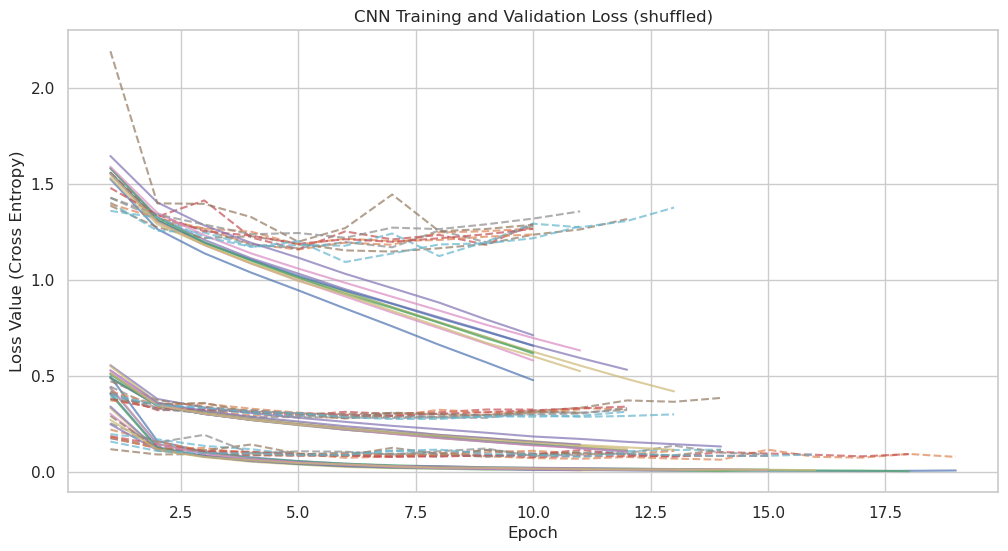

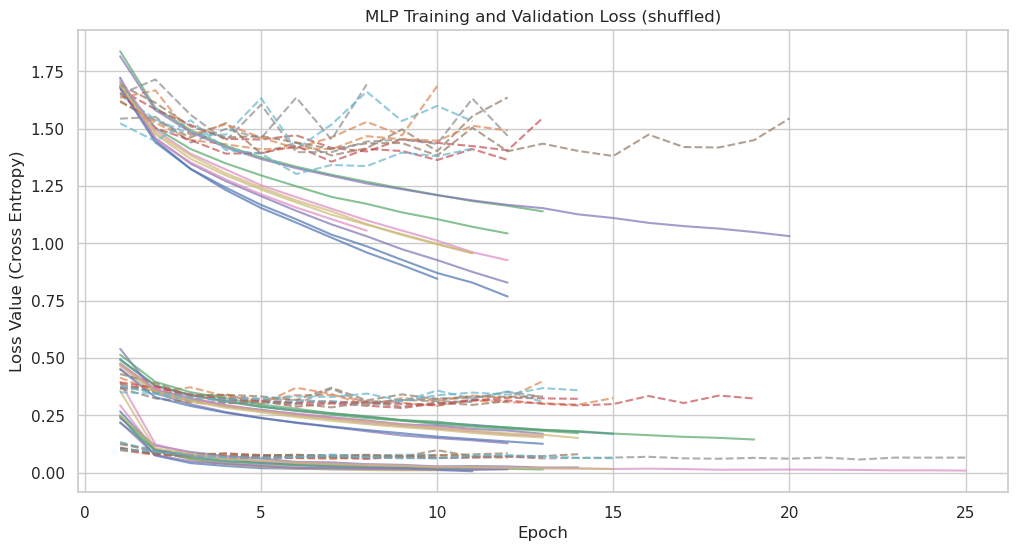

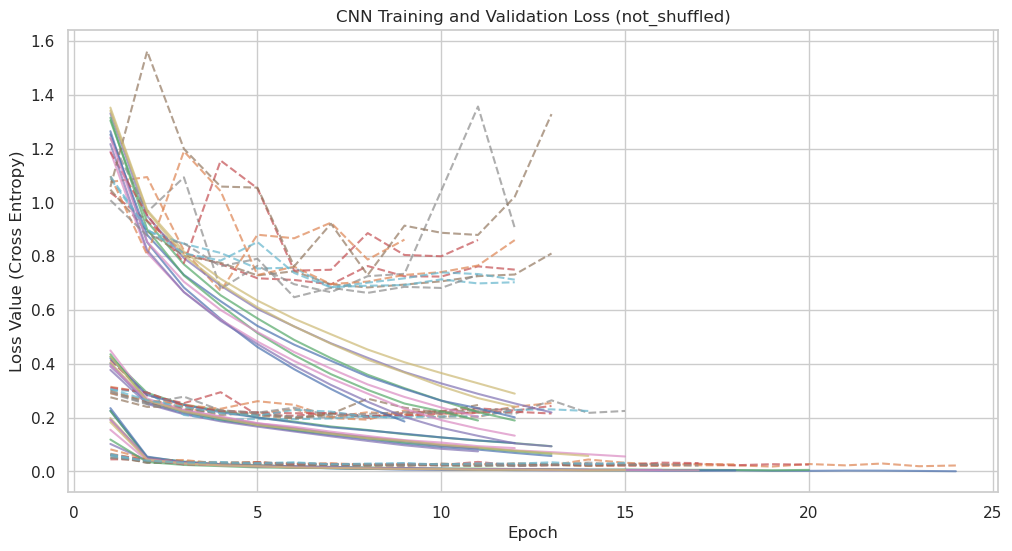

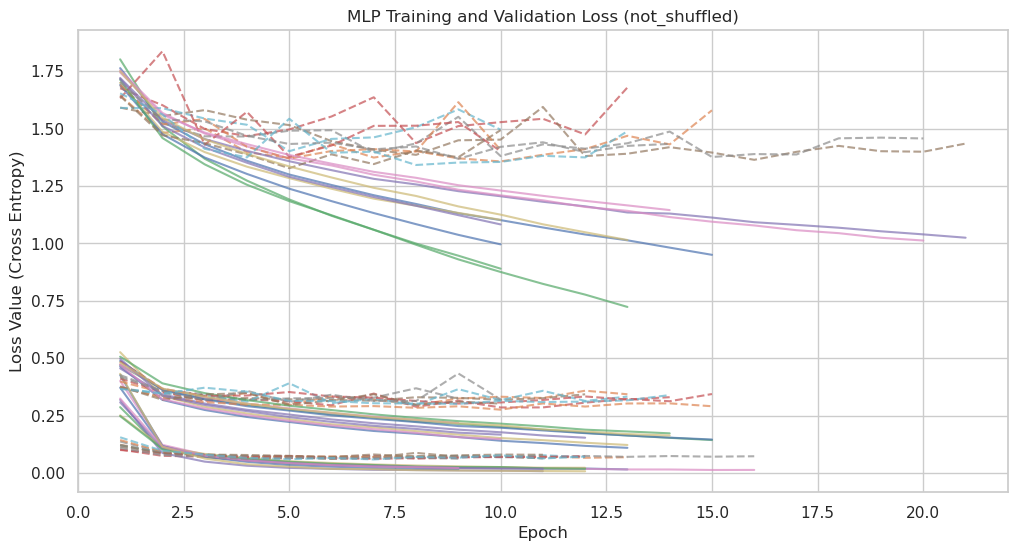

In [204]:
# Plot losses
plot_loss_curves(all_losses)

## 5. Compare metrics for each model and data type

In [205]:
combined_results.data_type

0                MNIST
1                MNIST
2                MNIST
3                MNIST
4                MNIST
            ...       
115    CIFAR10shuffled
116    CIFAR10shuffled
117    CIFAR10shuffled
118    CIFAR10shuffled
119    CIFAR10shuffled
Name: data_type, Length: 120, dtype: object

In [206]:
## Some quick formatting for the plotting esthetic
combined_results["Number of Parameters"] = combined_results["num_params"]

combined_results["data_type"] = combined_results["data_type"].apply(
    lambda x: x.replace("shuffled", " shuffled") if "shuffled" in x else x
)
combined_results

,model_index,fc1_hidden,fc2_hidden,fc3_hidden,learning_rate,batch_size,num_params,accuracy,f1,precision,recall,model_group,data_type,shuffled,cha_input,cha_hidden,fc_hidden,Number of Parameters
0,0,288.0,380.0,82.0,0.000182,32,369472,0.980970,0.980958,0.981011,0.980970,MLP,MNIST,False,NaN,NaN,NaN,369472
1,1,558.0,463.0,121.0,0.000213,32,756495,0.982071,0.982068,0.982094,0.982071,MLP,MNIST,False,NaN,NaN,NaN,756495
2,2,555.0,306.0,116.0,0.000318,120,644547,0.980924,0.980915,0.980944,0.980924,MLP,MNIST,False,NaN,NaN,NaN,644547
3,3,442.0,208.0,83.0,0.000156,32,458767,0.982272,0.982264,0.982318,0.982272,MLP,MNIST,False,NaN,NaN,NaN,458767
4,4,654.0,199.0,67.0,0.000940,32,659655,0.981170,0.981174,0.981230,0.981170,MLP,MNIST,False,NaN,NaN,NaN,659655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,5,NaN,NaN,NaN,0.000363,64,293758,0.590345,0.589300,0.590040,0.590345,CNN,CIFAR10 shuffled,True,50.0,75.0,171.0,293758
116,6,NaN,NaN,NaN,0.000283,120,367653,0.581124,0.580879,0.596096,0.581124,CNN,CIFAR10 shuffled,True,60.0,99.0,140.0,367653
117,7,NaN,NaN,NaN,0.001313,32,516291,0.583534,0.581219,0.582317,0.583534,CNN,CIFAR10 shuffled,True,47.0,115.0,187.0,516291
118,8,NaN,NaN,NaN,0.000219,32,362270,0.563101,0.562164,0.573857,0.563101,CNN,CIFAR10 shuffled,True,46.0,73.0,239.0,362270


/projects/aivich@xsede.org/code-server/tmp/ipykernel_3644316/551910515.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


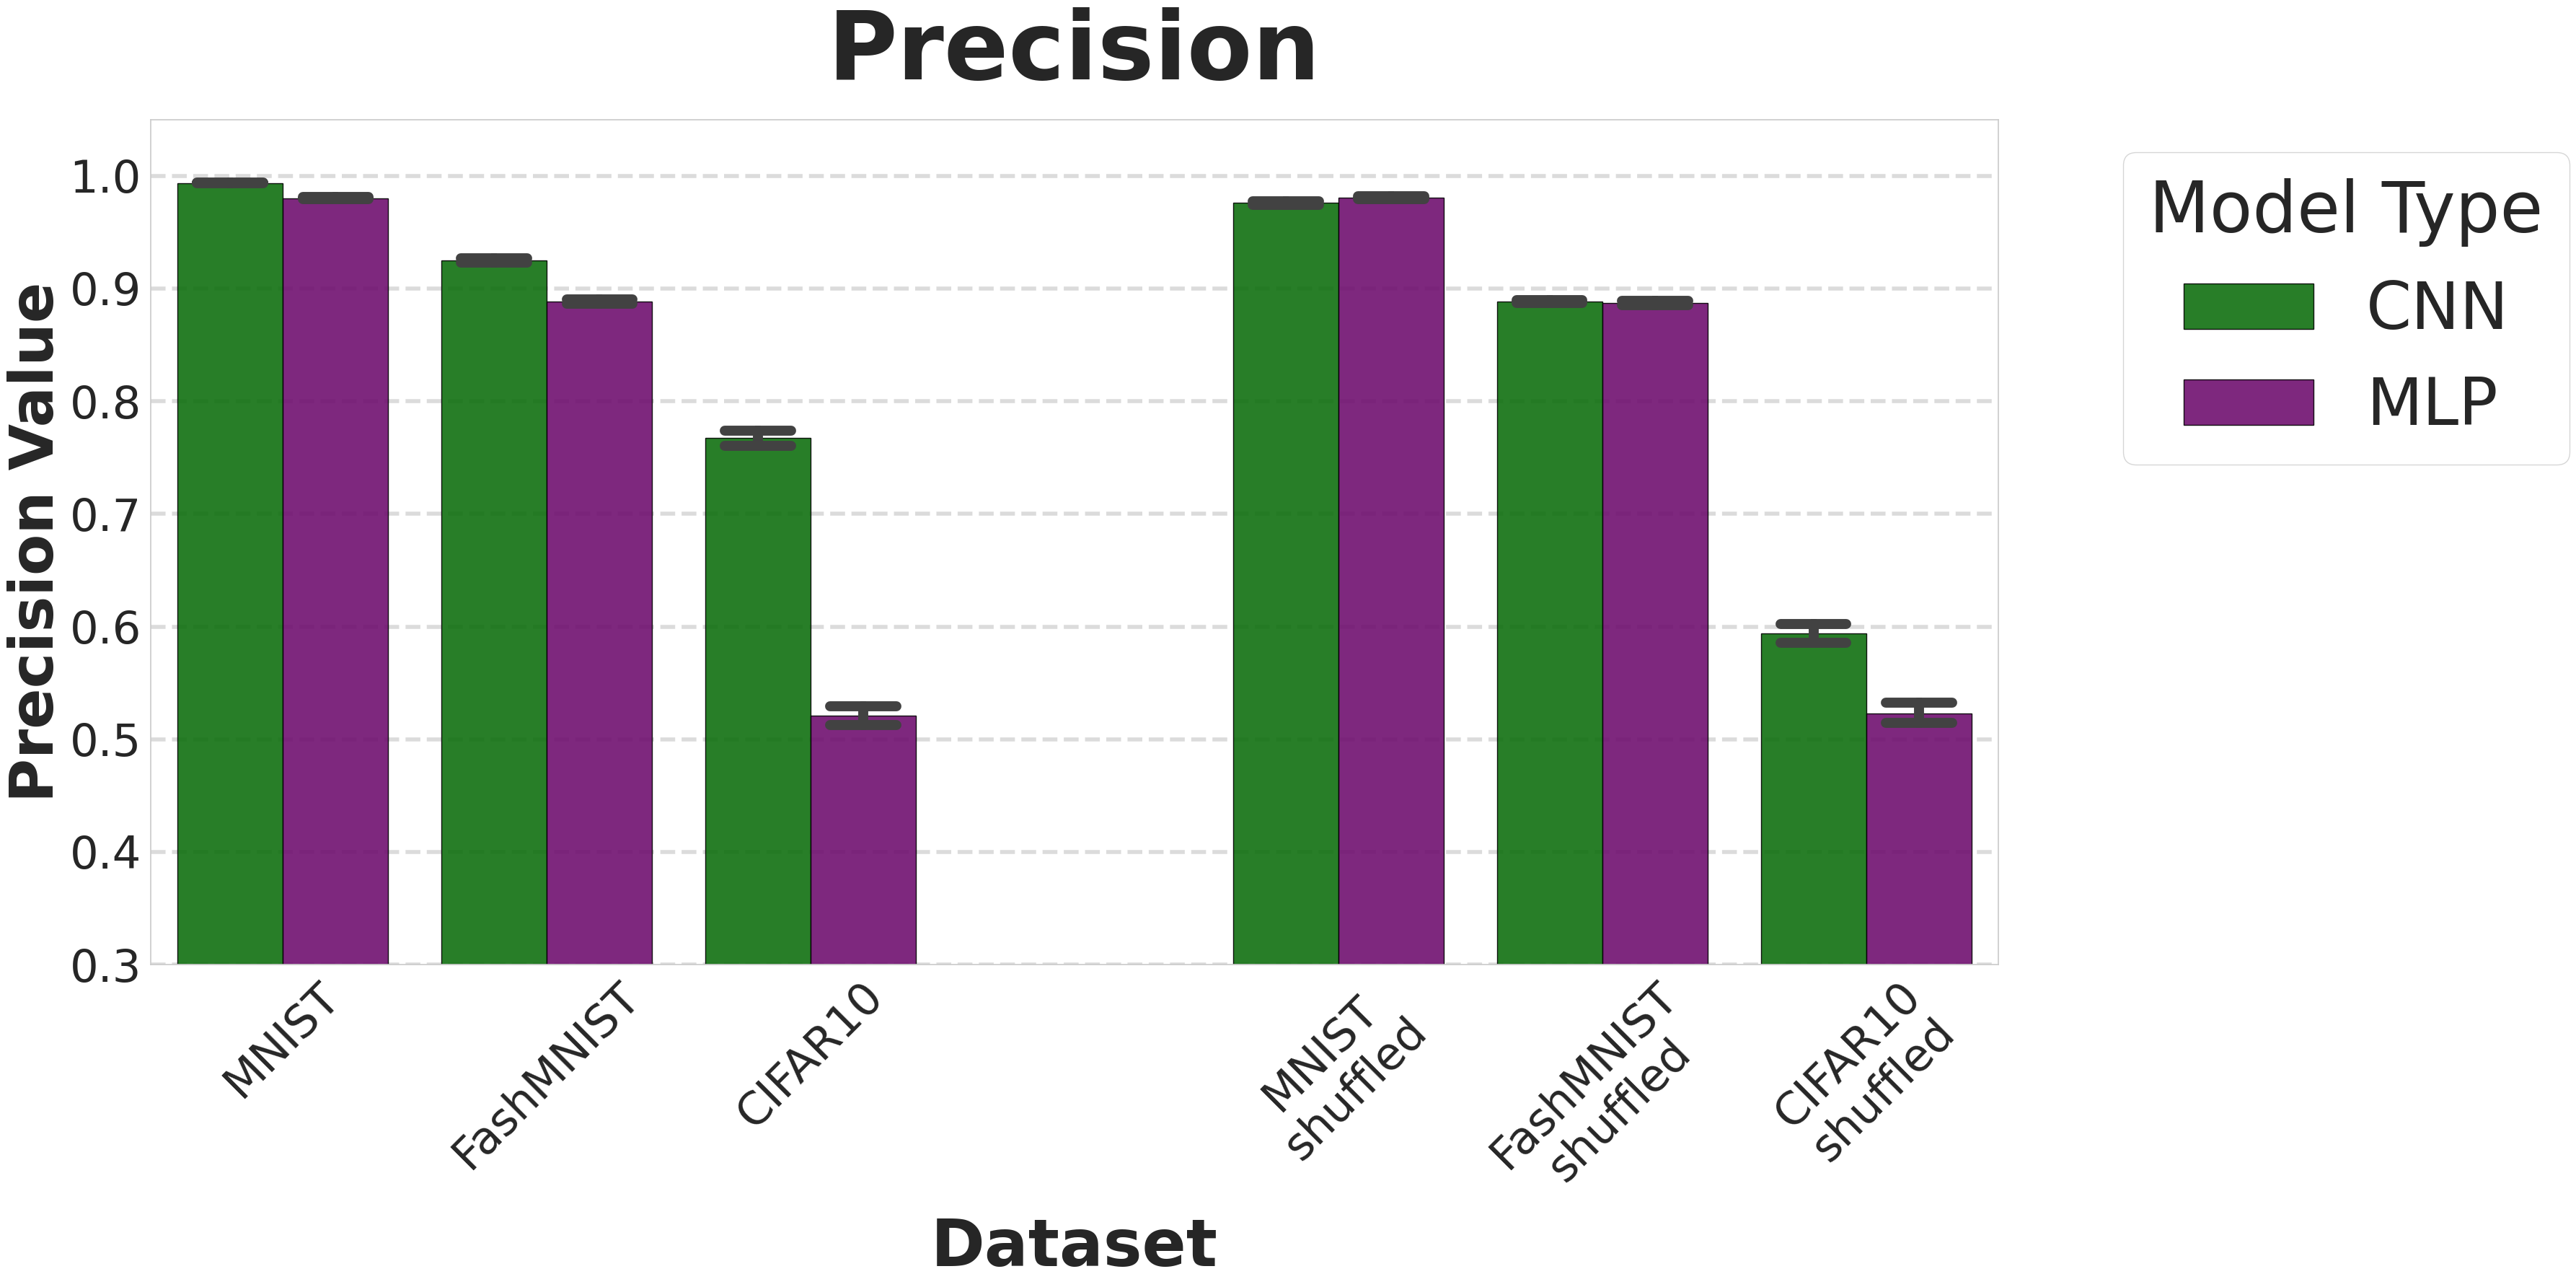

/projects/aivich@xsede.org/code-server/tmp/ipykernel_3644316/551910515.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


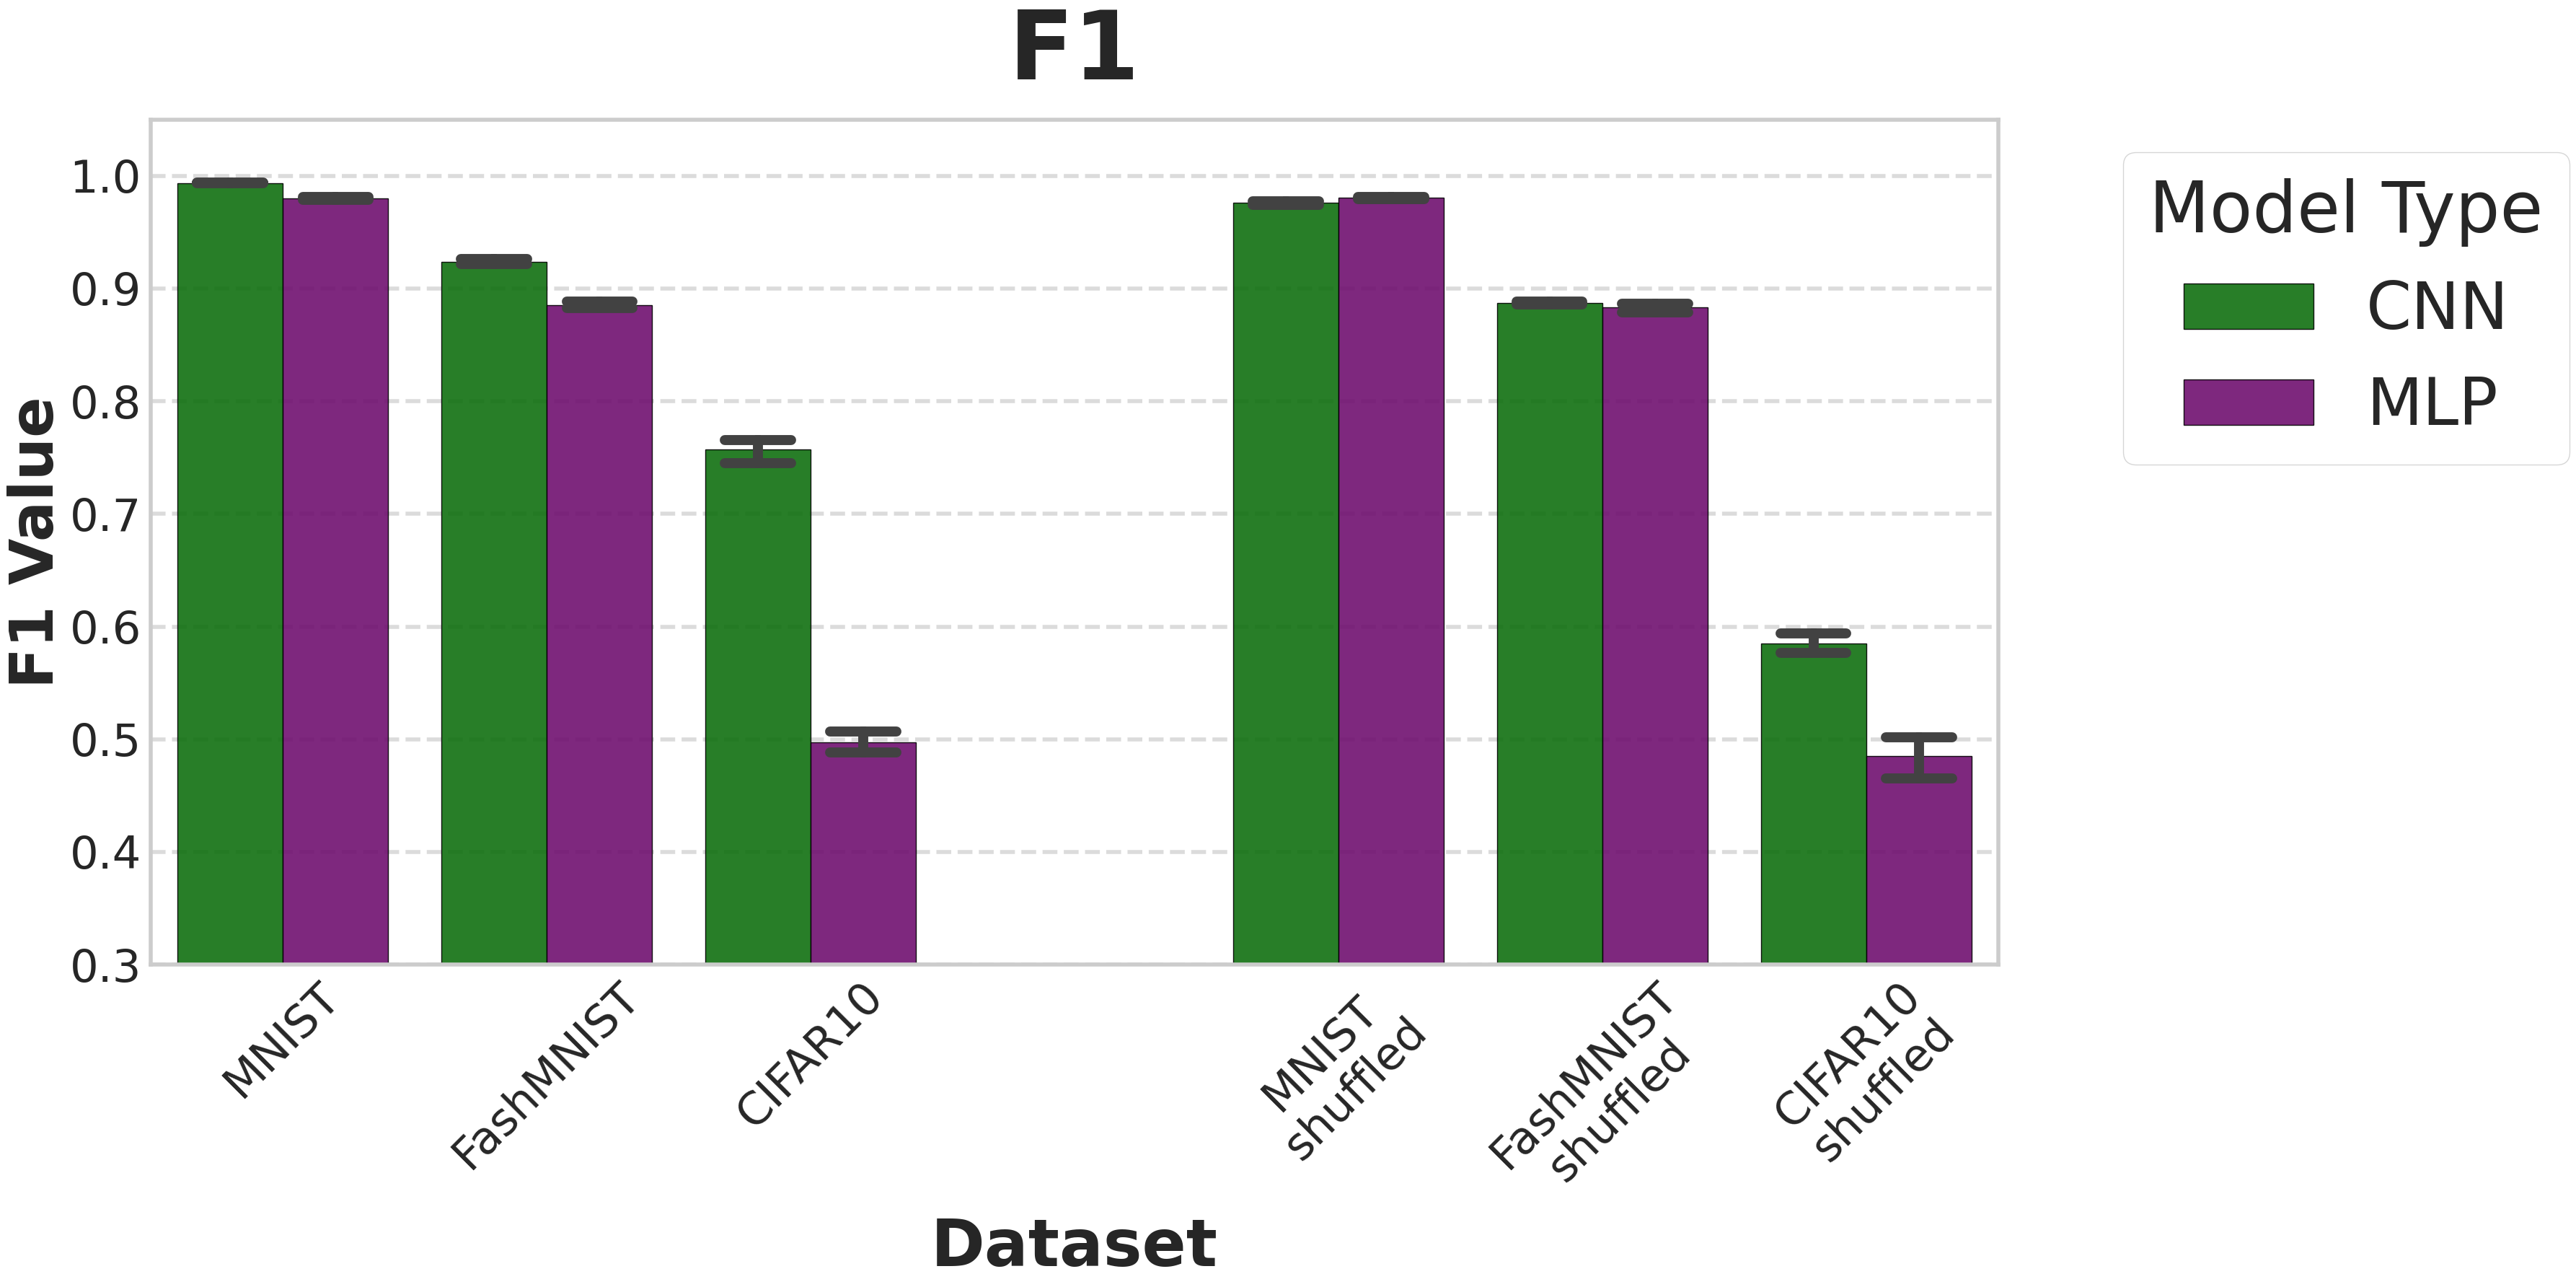

/projects/aivich@xsede.org/code-server/tmp/ipykernel_3644316/551910515.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


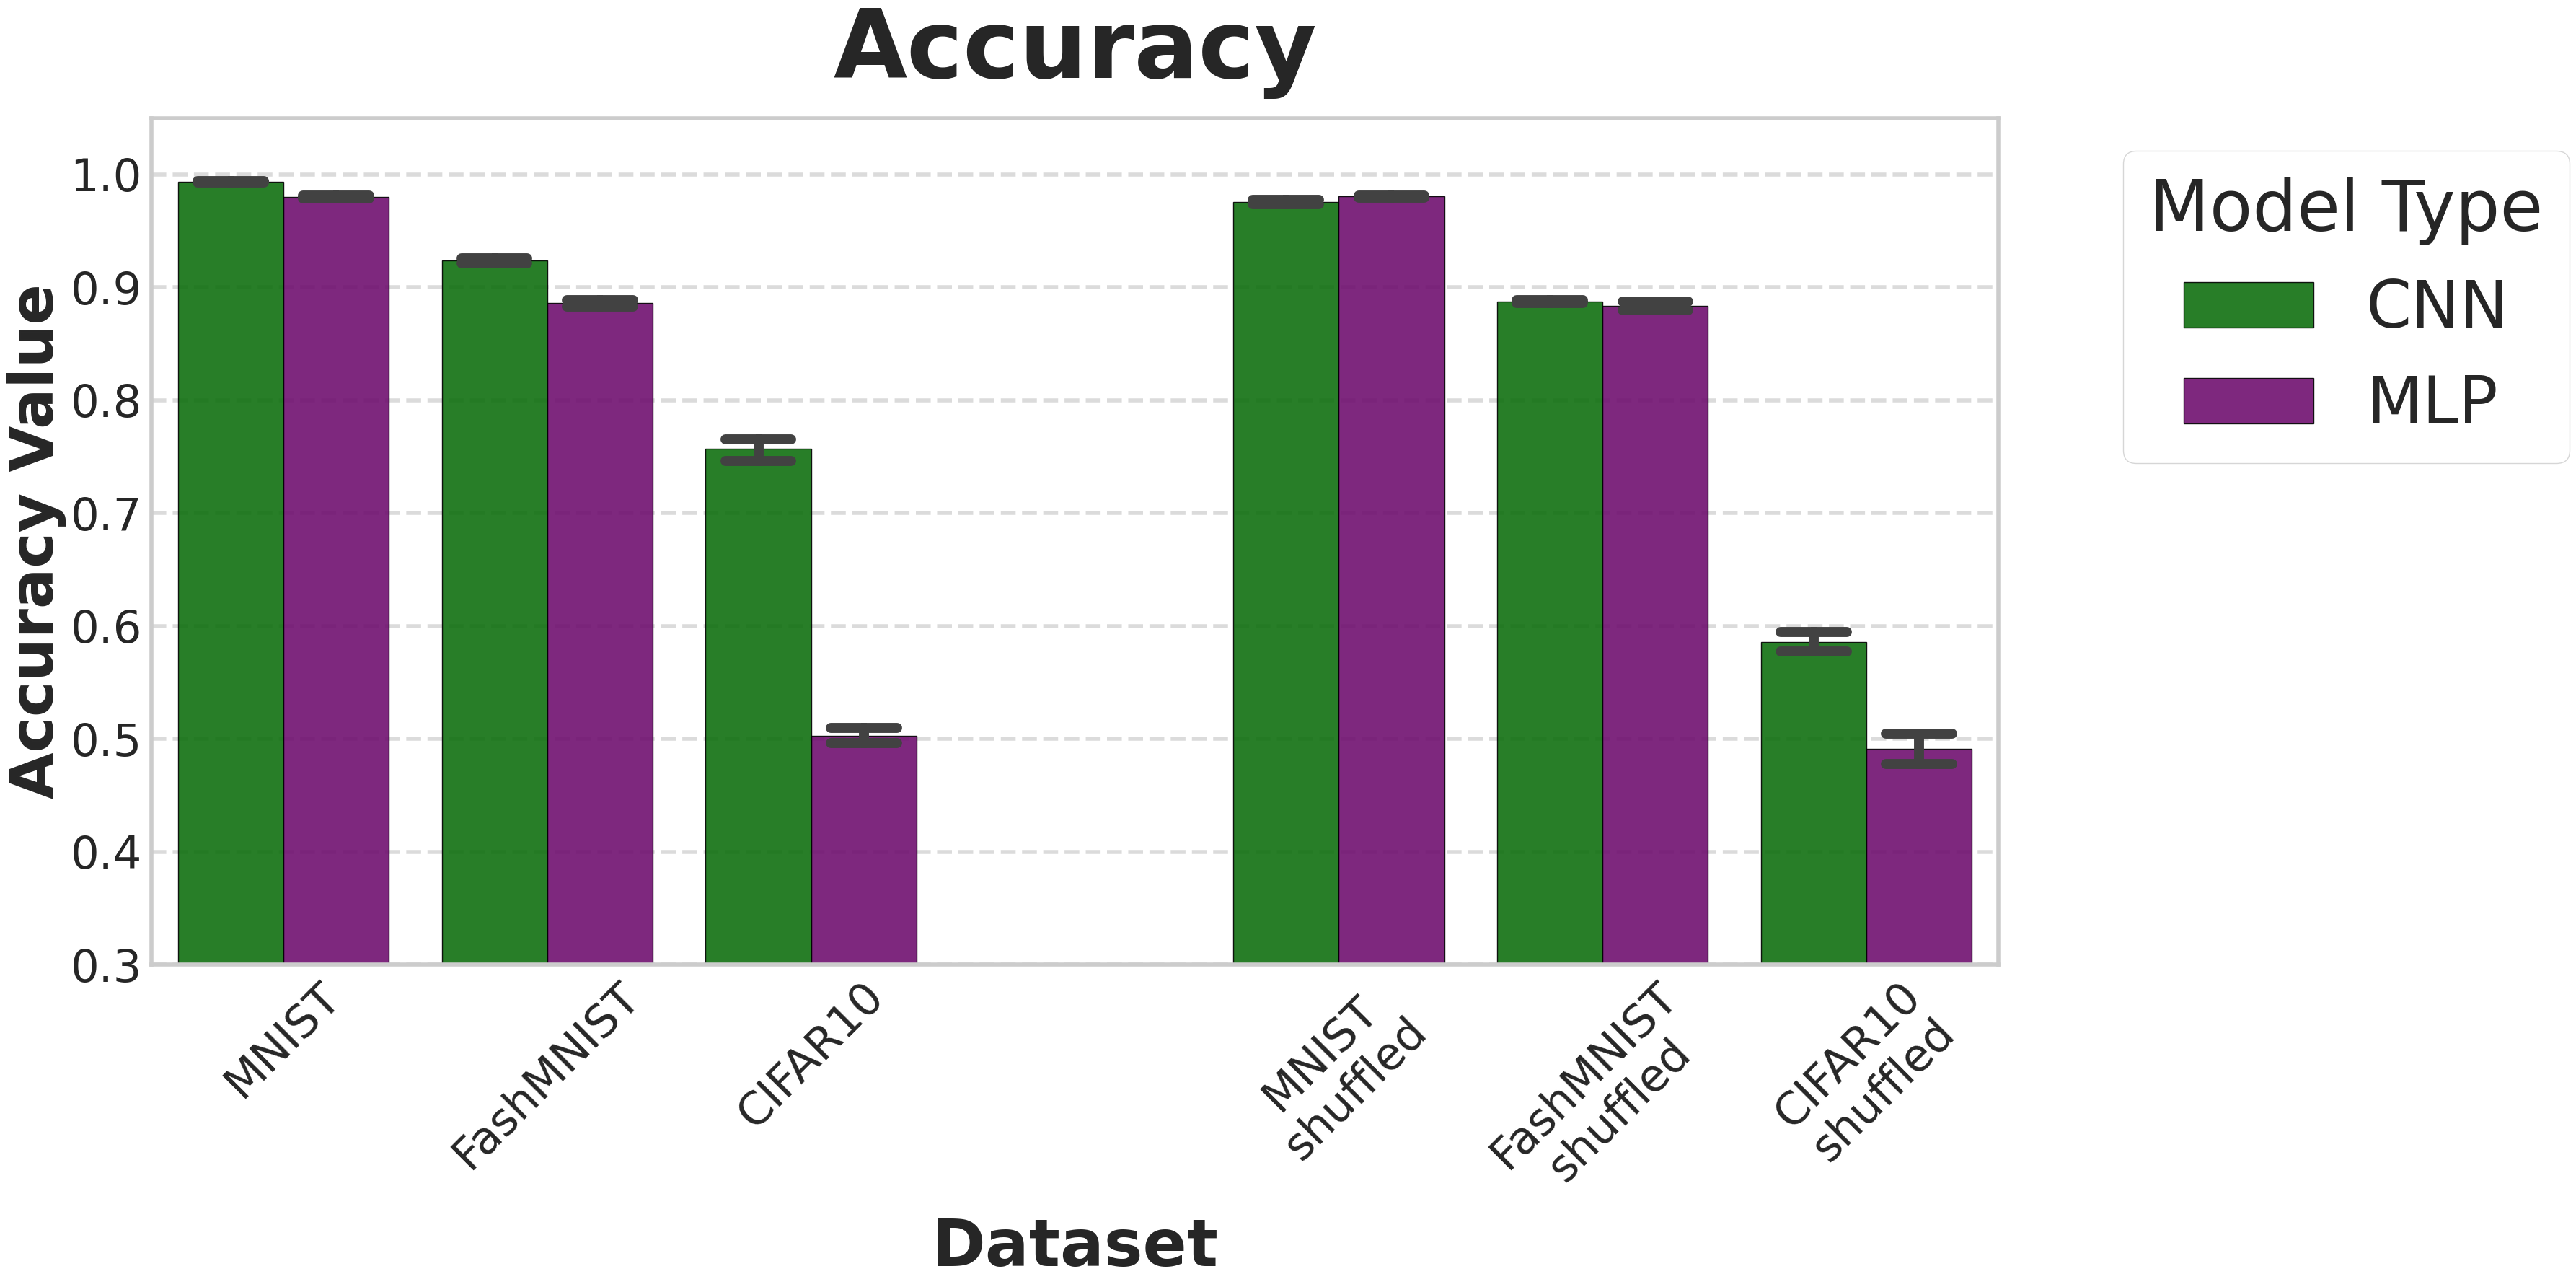

/projects/aivich@xsede.org/code-server/tmp/ipykernel_3644316/551910515.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


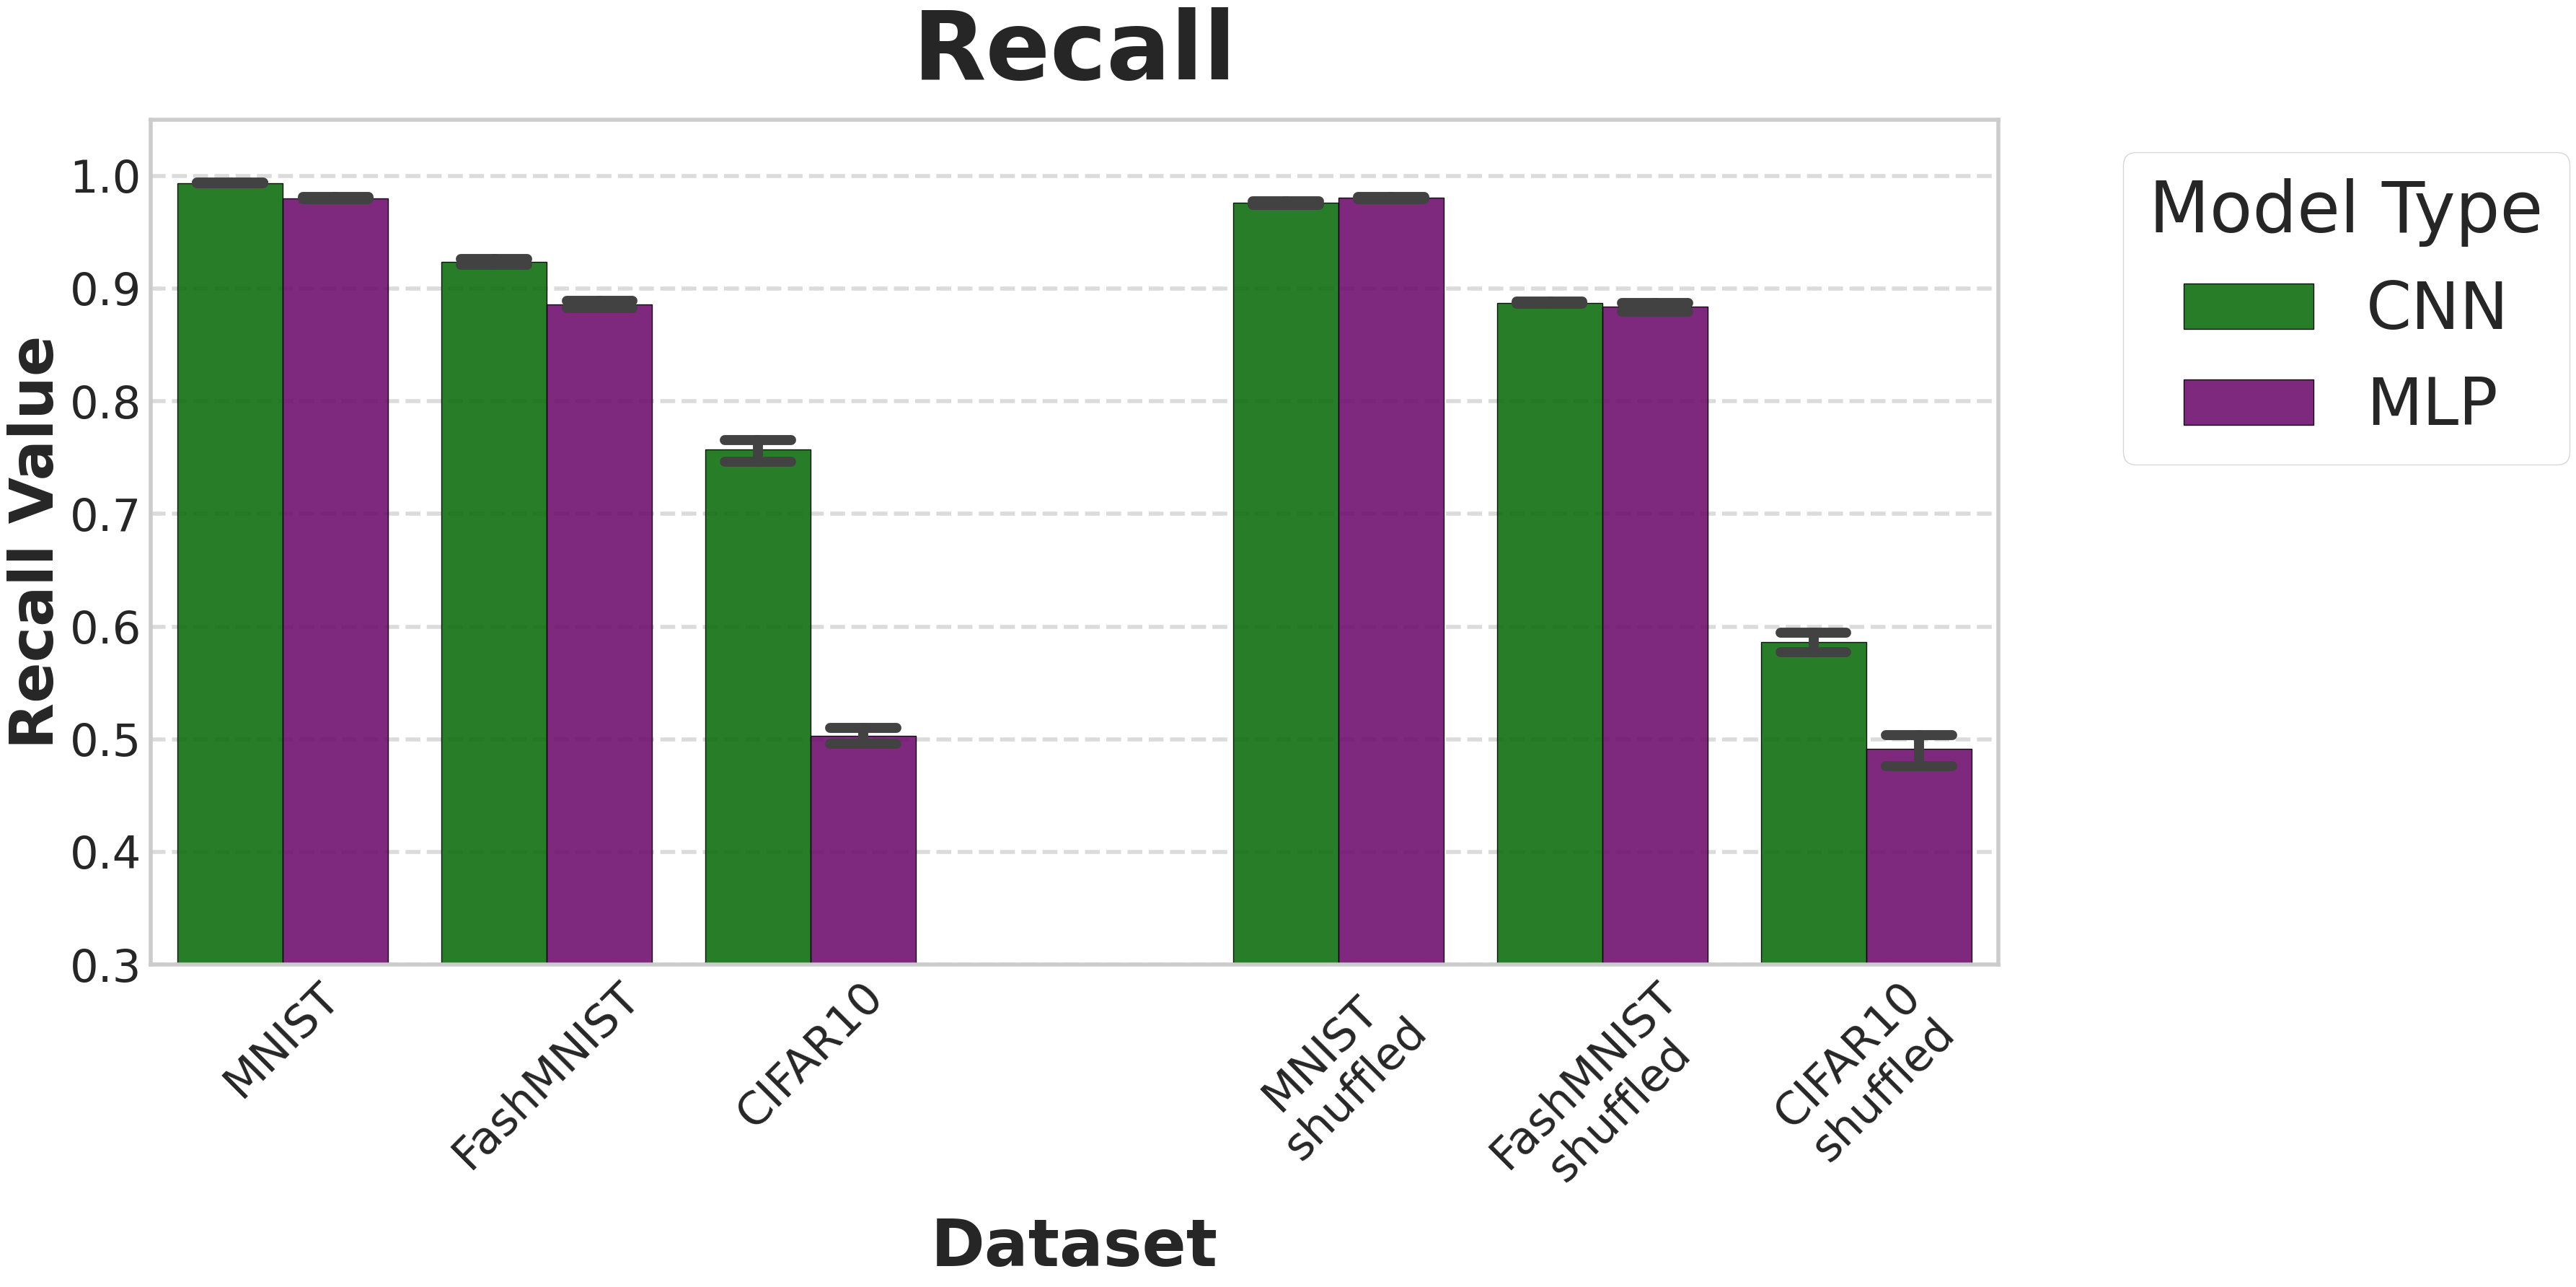

In [207]:
# Plots
for metric in ["precision", "f1", "accuracy", "recall"]:
    plot_boxplot(combined_results, metric, f"{metric.capitalize()}", 0.3, 1.05)


## 6. Statistical Analysis: Is it significant?

In [208]:

# Example usage: test across multiple "data_type" values and metrics
datasets = [
    "MNIST not_shuffled", "MNIST shuffled",
    "FashionMNIST not_shuffled", "FashionMNIST shuffled",
    "CIFAR10 not_shuffled", "CIFAR10 shuffled"
]

In [209]:
for d in datasets:
    for metric in ["precision", "f1", "accuracy", "recall"]:
        compare_models_statistically_for_dataset(combined_results, d, metric)


--- Dataset: MNIST not_shuffled, Metric: precision ---
Not enough data (fewer than 3 samples) for Shapiro–Wilk. Skipping.


--- Dataset: MNIST not_shuffled, Metric: f1 ---
Not enough data (fewer than 3 samples) for Shapiro–Wilk. Skipping.


--- Dataset: MNIST not_shuffled, Metric: accuracy ---
Not enough data (fewer than 3 samples) for Shapiro–Wilk. Skipping.


--- Dataset: MNIST not_shuffled, Metric: recall ---
Not enough data (fewer than 3 samples) for Shapiro–Wilk. Skipping.


--- Dataset: MNIST shuffled, Metric: precision ---
CNN Shapiro p=0.3152 | MLP Shapiro p=0.1835
Parametric test (two-sample t-test). p-value = 0.0011

--- Dataset: MNIST shuffled, Metric: f1 ---
CNN Shapiro p=0.3078 | MLP Shapiro p=0.1900
Parametric test (two-sample t-test). p-value = 0.0009

--- Dataset: MNIST shuffled, Metric: accuracy ---
CNN Shapiro p=0.3087 | MLP Shapiro p=0.1914
Parametric test (two-sample t-test). p-value = 0.0009

--- Dataset: MNIST shuffled, Metric: recall ---
CNN Shapiro p=0.3087 | M

Results are not conclusive from the above tests.

## 7. Compare model size (Number of trainable parameters)

/projects/aivich@xsede.org/code-server/tmp/ipykernel_3644316/1744503539.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/projects/aivich@xsede.org/code-server/tmp/ipykernel_3644316/1744503539.py:11: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/projects/aivich@xsede.org/code-server/tmp/ipykernel_3644316/1744503539.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/projects/aivich@xsede.org/code-server/tmp/ipykernel_3644316/1744503539.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable

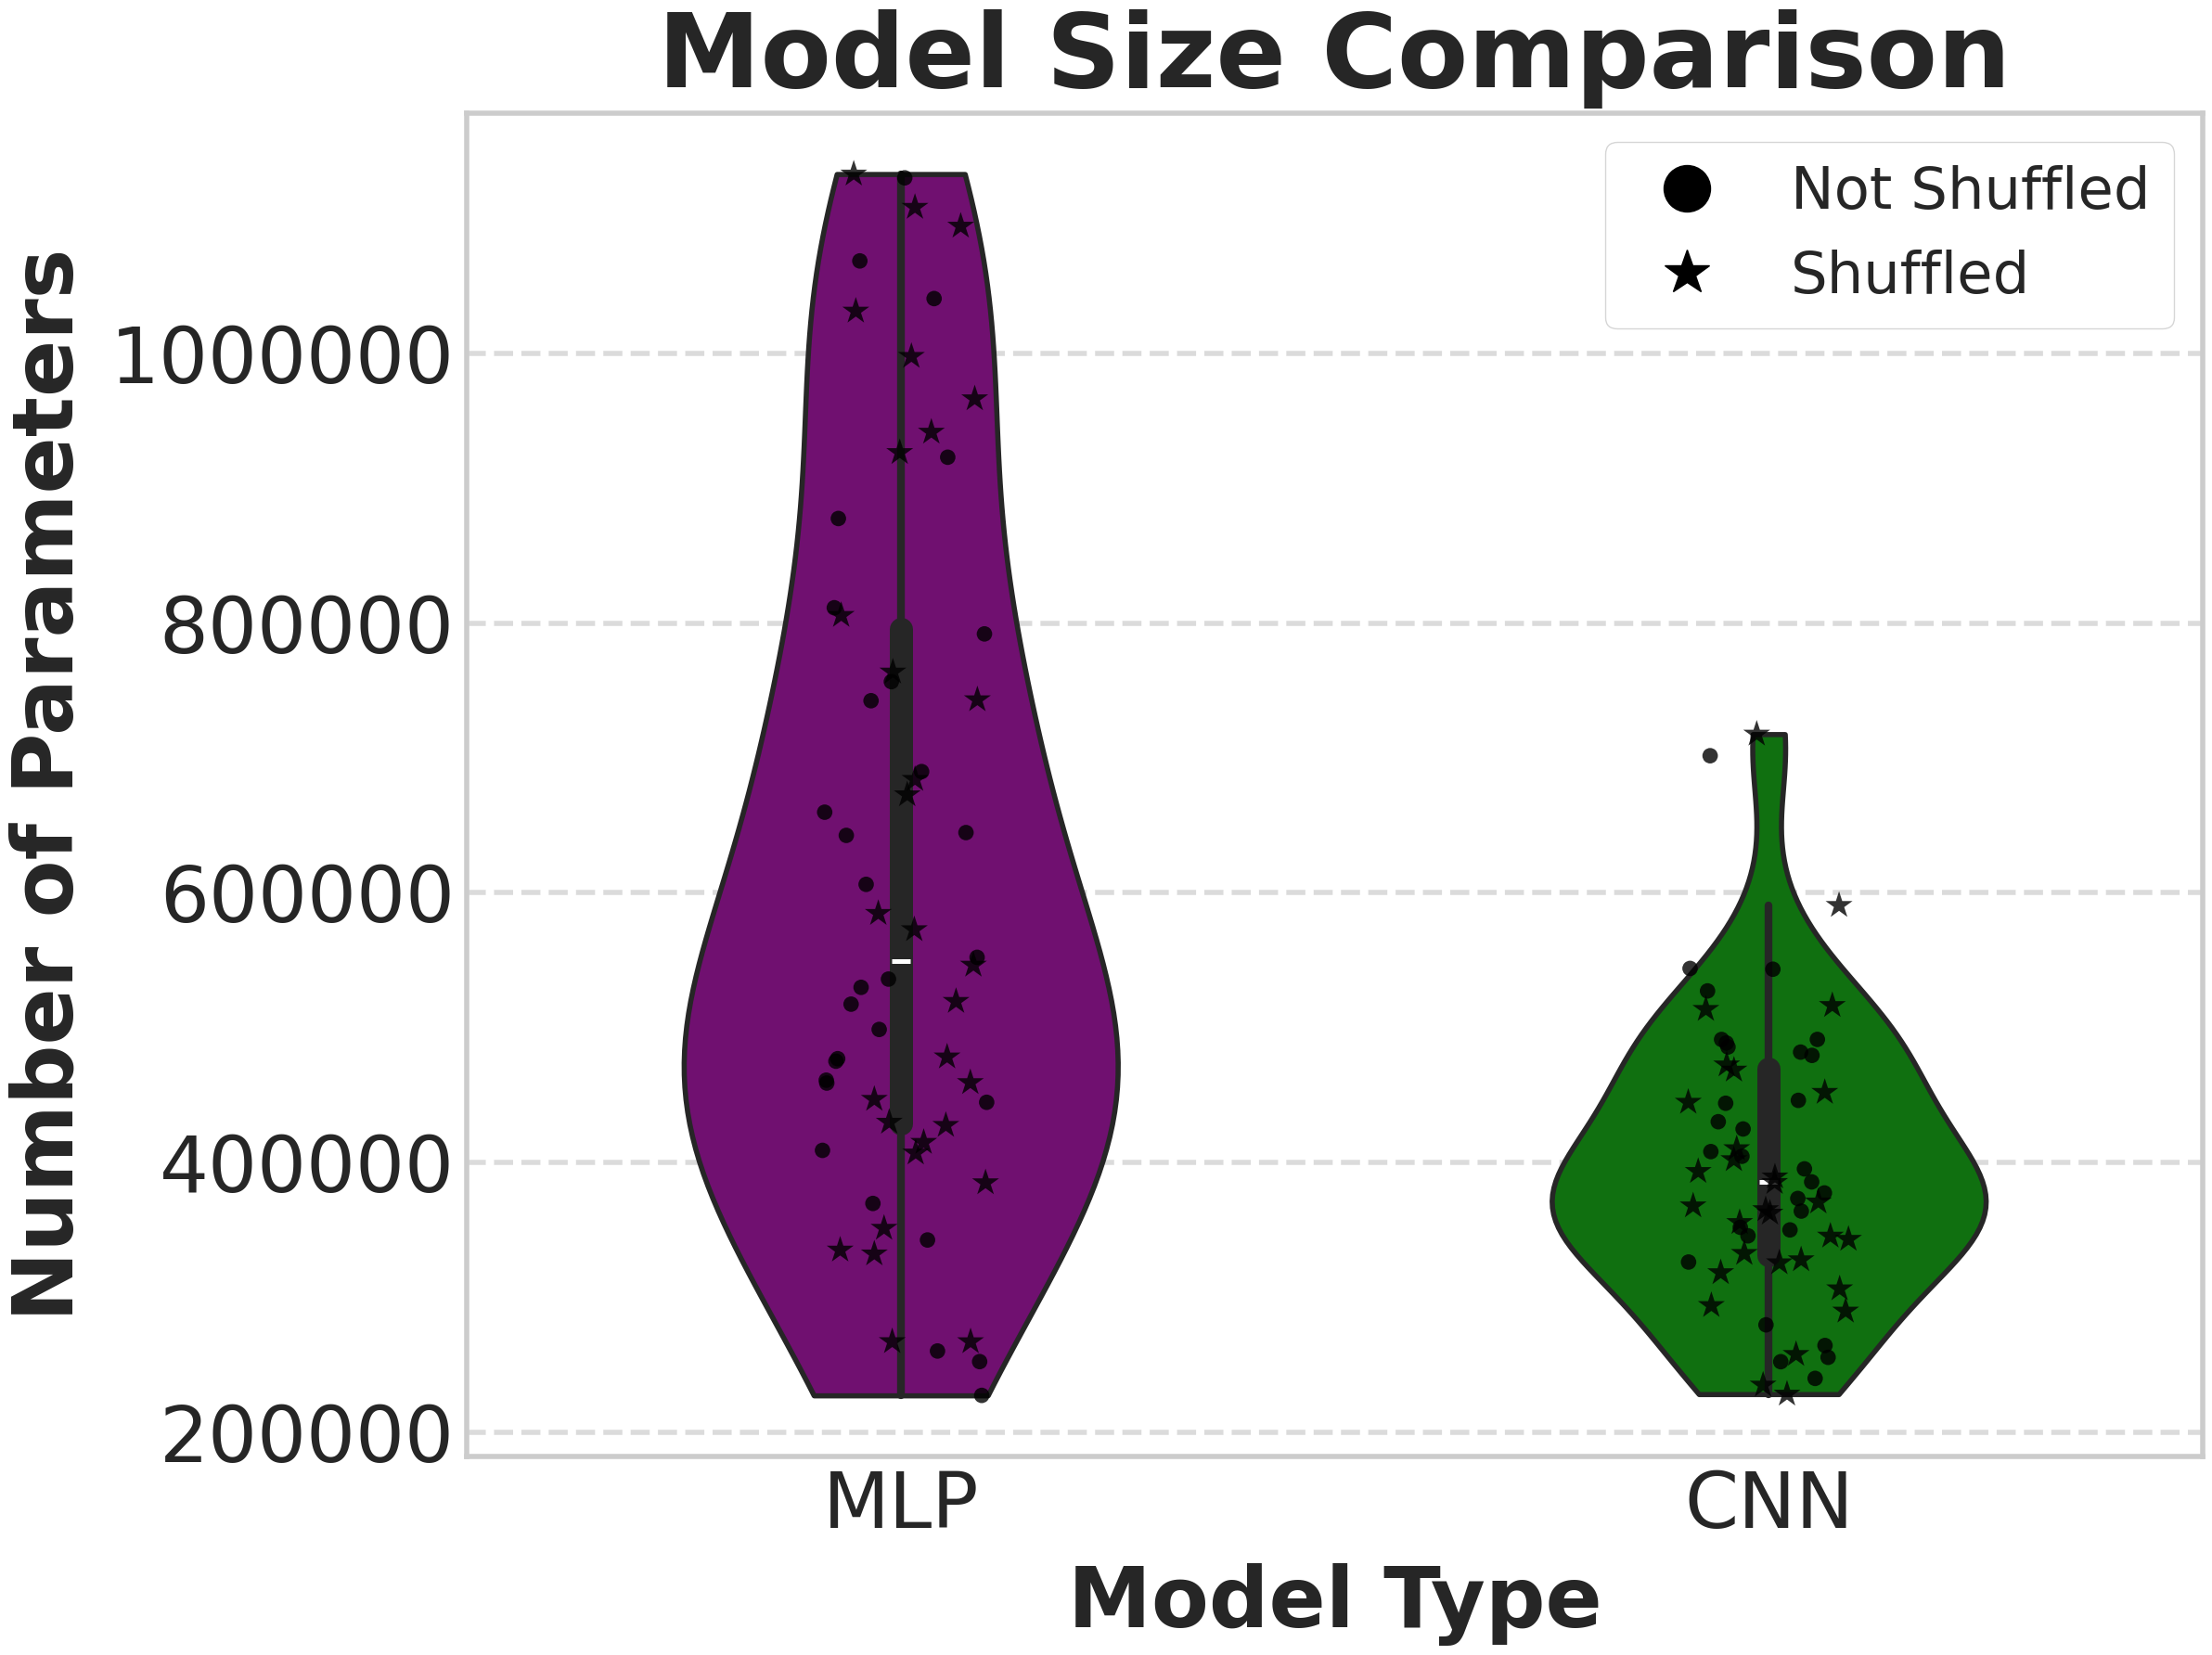

In [210]:
plot_model_size_comparison(combined_results)

## 8. Average Metrics Table

In [211]:
def generate_summary_table(combined_results):
    summary_table = combined_results.groupby(["data_type", "shuffled", "model_group"])[
        ["accuracy", "f1", "precision", "recall"]
    ].mean().reset_index()

    return summary_table

# Generate and display summary table
summary_table = generate_summary_table(combined_results)
summary_table["Dataset"] = summary_table.data_type
summary_table = summary_table.drop(columns="data_type")
summary_table["Model"] = summary_table.model_group
summary_table = summary_table.drop(columns="model_group")
summary_table["F1"] = summary_table.f1
summary_table= summary_table.drop(columns="f1")
summary_table["Precision"] = summary_table.precision
summary_table=summary_table.drop(columns="precision")
summary_table["Accuracy"] = summary_table.accuracy
summary_table= summary_table.drop(columns="accuracy")
summary_table["Recall"] = summary_table.recall
summary_table=summary_table.drop(columns="recall")
summary_table = summary_table.drop(columns="shuffled")
summary_table.index = summary_table.Dataset
summary_table= summary_table.drop(columns="Dataset")
summary_table

,Model,F1,Precision,Accuracy,Recall
Dataset,,,,,
CIFAR10,CNN,0.757066,0.767169,0.757304,0.757304
CIFAR10,MLP,0.497590,0.520793,0.502732,0.502732
CIFAR10 shuffled,CNN,0.585140,0.594053,0.586030,0.586030
CIFAR10 shuffled,MLP,0.485368,0.522824,0.491437,0.491437
FashMNIST,CNN,0.923695,0.924766,0.923575,0.923575
FashMNIST,MLP,0.885435,0.888593,0.885917,0.885917
FashMNIST shuffled,CNN,0.887084,0.888189,0.887323,0.887323
FashMNIST shuffled,MLP,0.883181,0.887107,0.883635,0.883635
MNIST,CNN,0.993534,0.993550,0.993535,0.993535
